### Import Libraries

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

### Import dataset

In [2]:
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
holdout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
train.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Kelly, Mrs. Florence ""Fannie""",male,NaN,NaN,NaN,CA. 2343,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [65]:
train["Sex"].value_counts(normalize=True)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

__PassengerID:__ Unique values<br>
__Survived:__ Target column, is either 1 (Passenger survived) or 0 (Passenger didn't survive)<br>
__Pclass:__ Passenger class, there are 3 unique classes (1, 2 and 3). Over 50% of the passengers were class 3<br>
__Name:__ Unique values, titles can be extracted<br>
__Sex:__ It has 2 unique values, either male or female. Approximately 64.8% of the passengers were male<br>
__Age:__ 75% of the passengers were 38 years old or younger. This column has null values<br>
__SibSP:__ Number of siblings and spouses, most passengers were travelling alone or with one sibling or spouse<br>
__Parch:__ Number of children, most passengers had no children aboard<br>
__Ticket:__ Mostly unique values<br>
__Fare:__ It has the highest standard deviation (approx. 50), it varies between 0 and approx. 512 and has one missing value in the holdout dataframe<br>
__Cabin:__ It has 4 unique values and has mostly missing values<br>
__Embarked:__ It has 3 unique values and some missing values

### Preparing the dataset

#### Pclass:

In [13]:
train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [14]:
def create_dummies(df, column_name):
    dummies = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df, dummies], axis=1)
    return df

In [15]:
train = create_dummies(train, "Pclass")
holdout = create_dummies(holdout, "Pclass")

#### Name:

In [16]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

extracted_titles = train["Name"].str.extract(' (\w+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)
extracted_titles = holdout["Name"].str.extract(' (\w+)\.',expand=False)
holdout["Title"] = extracted_titles.map(titles)

In [17]:
train["Title"].value_counts()

Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      5
Name: Title, dtype: int64

In [18]:
train = create_dummies(train, "Title")
holdout = create_dummies(holdout, "Title")

#### Sex:

In [19]:
train["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [20]:
train = create_dummies(train, "Sex")
holdout = create_dummies(holdout, "Sex")

#### Age:

In [21]:
def process_age(df, cut_points, label_names):
    df["Age"] = df["Age"].fillna(-1)
    df["Age"] = df["Age"].apply(round)
    df["Age_categories"] = pd.cut(df["Age"], cut_points, labels=label_names)
    return df

In [22]:
cut_points = [-2, 0, 15, 30, 45, 60, 75, 90]
label_names = ["Missing", "0-14", "15-29", "30-44", "45-59", "60-74", "75-90"]

In [23]:
train = process_age(train, cut_points, label_names)
holdout = process_age(holdout, cut_points, label_names)

In [24]:
train = create_dummies(train, "Age_categories")
holdout = create_dummies(holdout, "Age_categories")

#### SibSp:

In [25]:
train["SibSp"].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [27]:
train["SibSp_scaled"] = minmax_scale(train["SibSp"].astype(float))
holdout["SibSp_scaled"] = minmax_scale(holdout["SibSp"].astype(float))

#### Parch:

In [29]:
train["Parch"].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [30]:
train["Parch_scaled"] = minmax_scale(train["Parch"].astype(float))
holdout["Parch_scaled"] = minmax_scale(holdout["Parch"].astype(float))

#### Fare:

Fill missing values in the holdout dataset:

In [31]:
holdout["Fare"] = holdout["Fare"].fillna(np.median(train["Fare"]))

In [32]:
train["Fare_scaled"] = minmax_scale(train["Fare"].astype(float))
holdout["Fare_scaled"] = minmax_scale(holdout["Fare"].astype(float))

#### Cabin:

Extract first char and fill missing values:

In [33]:
train["Cabin_type"] = train["Cabin"].str[0]
train["Cabin_type"] = train["Cabin_type"].fillna("Unknown")

holdout["Cabin_type"] = holdout["Cabin"].str[0]
holdout["Cabin_type"] = holdout["Cabin_type"].fillna("Unknown")

In [34]:
train["Cabin_type"].value_counts()

Unknown    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: Cabin_type, dtype: int64

In [35]:
train = create_dummies(train, "Cabin_type")
holdout = create_dummies(holdout, "Cabin_type")

#### Embarked:

In [36]:
train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [37]:
train["Embarked"] = train["Embarked"].fillna("S")
holdout["Embarked"] = holdout["Embarked"].fillna("S")

In [38]:
train = create_dummies(train, "Embarked")
holdout = create_dummies(holdout, "Embarked")

### Checking datasets:

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 48 columns):
PassengerId               891 non-null int64
Survived                  891 non-null int64
Pclass                    891 non-null int64
Name                      891 non-null object
Sex                       891 non-null object
Age                       891 non-null int64
SibSp                     891 non-null int64
Parch                     891 non-null int64
Ticket                    891 non-null object
Fare                      891 non-null float64
Cabin                     204 non-null object
Embarked                  891 non-null object
Pclass_1                  891 non-null uint8
Pclass_2                  891 non-null uint8
Pclass_3                  891 non-null uint8
Title                     891 non-null object
Title_Master              891 non-null uint8
Title_Miss                891 non-null uint8
Title_Mr                  891 non-null uint8
Title_Mrs                 891 no

In [40]:
holdout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 46 columns):
PassengerId               418 non-null int64
Pclass                    418 non-null int64
Name                      418 non-null object
Sex                       418 non-null object
Age                       418 non-null int64
SibSp                     418 non-null int64
Parch                     418 non-null int64
Ticket                    418 non-null object
Fare                      418 non-null float64
Cabin                     91 non-null object
Embarked                  418 non-null object
Pclass_1                  418 non-null uint8
Pclass_2                  418 non-null uint8
Pclass_3                  418 non-null uint8
Title                     418 non-null object
Title_Master              418 non-null uint8
Title_Miss                418 non-null uint8
Title_Mr                  418 non-null uint8
Title_Mrs                 418 non-null uint8
Title_Officer             418 non

Cabin_type_T column appears in train dataframe but not in holdout dataframe as it has only 1 value.

In [41]:
train = train.drop("Cabin_type_T", axis=1)

In [42]:
len(train.columns)

47

In [43]:
len(holdout.columns)

46

The difference between the number of columns from train dataframe and holdout dataframe is due to the missing target column "Survived" in the holdout dataframe.

### Data visualisation

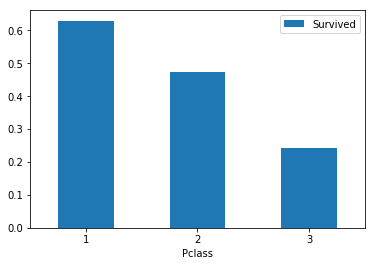

In [45]:
pclass_pivot = train.pivot_table(index="Pclass", values="Survived").sort_values(by="Survived", ascending=False)
pclass_pivot.plot.bar()
plt.xticks(rotation="horizontal")
plt.show()

It seems that passengers from class 1 got a higher survival rate.

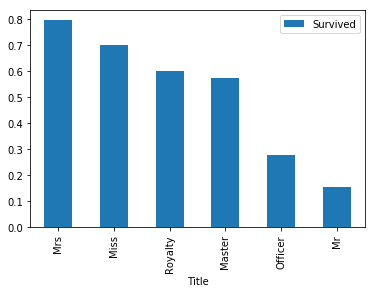

In [50]:
title_pivot = train.pivot_table(index="Title", values="Survived").sort_values(by="Survived", ascending=False)
title_pivot.plot.bar()
plt.show()

By looking the Title vs Survival Rate, seems that mostly females survived.

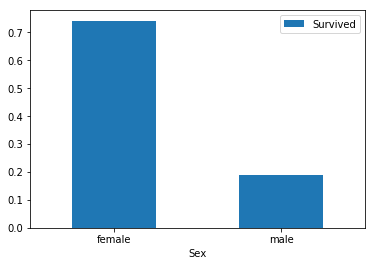

In [52]:
sex_pivot = train.pivot_table(index="Sex", values="Survived").sort_values(by="Survived", ascending=False)
sex_pivot.plot.bar()
plt.xticks(rotation="horizontal")
plt.show()

We can confirm here that mostly females survived.

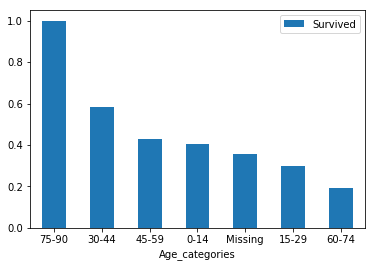

In [53]:
age_pivot = train.pivot_table(index="Age_categories", values="Survived").sort_values(by="Survived", ascending=False)
age_pivot.plot.bar()
plt.xticks(rotation="horizontal")
plt.show()

In [64]:
train["Age_categories"].value_counts(normalize=True)

15-29      0.368126
30-44      0.224467
Missing    0.199776
0-14       0.092031
45-59      0.090909
60-74      0.023569
75-90      0.001122
Name: Age_categories, dtype: float64

The dataset has fewer seniors, so the survival rate is skewed by them, it's safer to infer that mostly adults survived as their quantity are higher.

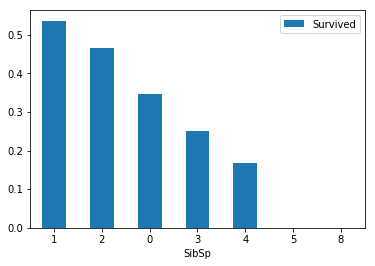

In [58]:
sibsp_pivot = train.pivot_table(index="SibSp", values="Survived").sort_values(by="Survived", ascending=False)
sibsp_pivot.plot.bar()
plt.xticks(rotation="horizontal")
plt.show()

Most survivals had one sibling or spouse onboard.

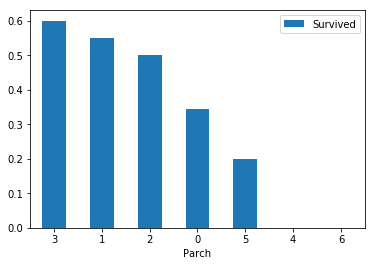

In [69]:
parch_pivot = train.pivot_table(index="Parch", values="Survived").sort_values(by="Survived", ascending=False)
parch_pivot.plot.bar()
plt.xticks(rotation="horizontal")
plt.show()

In [63]:
train["Parch"].value_counts(normalize=True)

0    0.760943
1    0.132435
2    0.089787
5    0.005612
3    0.005612
4    0.004489
6    0.001122
Name: Parch, dtype: float64

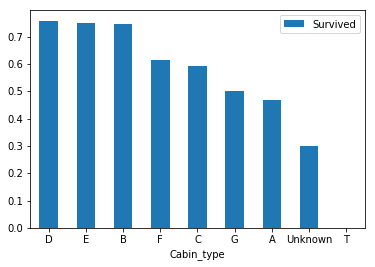

In [73]:
cabin_pivot = train.pivot_table(index="Cabin_type", values="Survived").sort_values(by="Survived", ascending=False)
cabin_pivot.plot.bar()
plt.xticks(rotation="horizontal")
plt.show()

In [74]:
train["Cabin_type"].value_counts(normalize=True)

Unknown    0.771044
C          0.066218
B          0.052750
D          0.037037
E          0.035915
A          0.016835
F          0.014590
G          0.004489
T          0.001122
Name: Cabin_type, dtype: float64

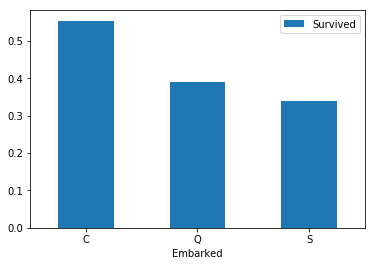

In [76]:
embarked_pivot = train.pivot_table(index="Embarked", values="Survived").sort_values(by="Survived", ascending=False)
embarked_pivot.plot.bar()
plt.xticks(rotation="horizontal")
plt.show()

### Exploring correlations

In [77]:
columns = train.columns[12:].drop(["Title", "Age_categories", "Cabin_type"])

In [78]:
columns

Index(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Sex_female',
       'Sex_male', 'Age_categories_Missing', 'Age_categories_0-14',
       'Age_categories_15-29', 'Age_categories_30-44', 'Age_categories_45-59',
       'Age_categories_60-74', 'Age_categories_75-90', 'SibSp_scaled',
       'Parch_scaled', 'Fare_scaled', 'Cabin_type_A', 'Cabin_type_B',
       'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F',
       'Cabin_type_G', 'Cabin_type_Unknown', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

In [79]:
def plot_correlation_heatmap(df):
    corr = df.corr()

    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

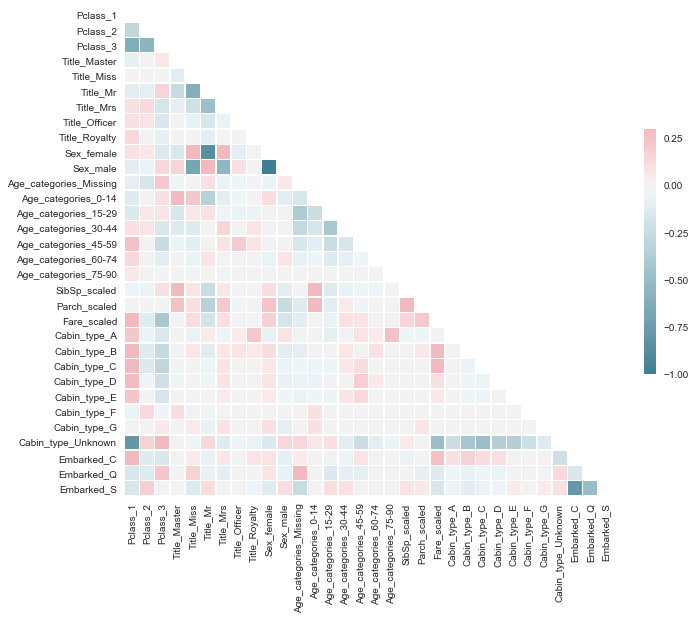

In [80]:
plot_correlation_heatmap(train[columns])

High correlations between Pclasses columns, Sex columns, Title columns with Sex columns and Embarked_C with Embarked_S column.
Drop some columns to prevent overfitting the model.

In [81]:
columns = columns.drop(["Pclass_1", "Sex_male", "Title_Mr", "Cabin_type_Unknown", "Embarked_C"])

columns

Index(['Pclass_2', 'Pclass_3', 'Title_Master', 'Title_Miss', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Sex_female',
       'Age_categories_Missing', 'Age_categories_0-14', 'Age_categories_15-29',
       'Age_categories_30-44', 'Age_categories_45-59', 'Age_categories_60-74',
       'Age_categories_75-90', 'SibSp_scaled', 'Parch_scaled', 'Fare_scaled',
       'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

### Testing models

#### Logistic Regression

In [82]:
all_X = train[columns]
all_y = train["Survived"]

lr = LogisticRegression()
selector = RFECV(lr, cv=10)
selector.fit(all_X, all_y)

RFECV(cv=10,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

In [92]:
optimized_columns = all_X.columns[selector.support_]

optimized_columns

Index(['Pclass_2', 'Pclass_3', 'Title_Master', 'Title_Miss', 'Title_Mrs',
       'Sex_female', 'Age_categories_0-14', 'Age_categories_45-59',
       'Age_categories_60-74', 'Age_categories_75-90', 'SibSp_scaled',
       'Parch_scaled', 'Fare_scaled', 'Cabin_type_A', 'Cabin_type_B',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Embarked_S'],
      dtype='object')

In [84]:
all_X = train[optimized_columns]
all_y = train["Survived"]

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
scores.mean()

0.833916127567813

#### K-Neighbors Classifier

In [85]:
hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ["brute"],
    "p": [1, 2]
}
all_X = train[columns]

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid=hyperparameters, cv=10)
grid.fit(all_X, all_y)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(1, 20, 2), 'weights': ['distance', 'uniform'], 'algorithm': ['brute'], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [86]:
grid.best_params_

{'algorithm': 'brute', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}

In [87]:
grid.best_score_

0.8305274971941639

#### Random Forest Classifier

In [89]:
hyperparameters = {
    "criterion": ["entropy", "gini"],
    "max_depth": [5, 10],
    "max_features": ["log2", "sqrt"],
    "min_samples_leaf": [1, 5],
    "min_samples_split": [3, 5],
    "n_estimators": [6, 9]
}
all_X = train[columns]

clf = RandomForestClassifier()
grid = GridSearchCV(clf, param_grid=hyperparameters, cv=10)
grid.fit(all_X, all_y)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['entropy', 'gini'], 'max_depth': [5, 10], 'max_features': ['log2', 'sqrt'], 'min_samples_leaf': [1, 5], 'min_samples_split': [3, 5], 'n_estimators': [6, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [90]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 9}

In [91]:
grid.best_score_

0.8316498316498316

All models scores are similar, but the Logistic Regression model went slightly better.

### Submission

In [94]:
all_X = train[optimized_columns]
all_y = train["Survived"]

lr = LogisticRegression()
lr.fit(all_X, all_y)
holdout_predictions = lr.predict(holdout[optimized_columns])

In [95]:
holdout_ids = holdout["PassengerId"]
submission_df = {
    "PassengerID": holdout_ids,
    "Survived" : holdout_predictions
}
submission = pd.DataFrame(submission_df)
submission.to_csv("submission_titanic_LR.csv", index=False)